In [1]:
import os
import numpy as np
datapath = '/data/gtEx'
pairfile = os.path.join(datapath, 'Brain_Caudate_basal_ganglia_Analysis_cis-eQTLs.txt')
snpfile = os.path.join(datapath, 'GTEx_Analysis_2015-01-12_OMNI_2.5M_5M_450Indiv_chr1-22+X_genot_imput_info04_maf01_HWEp1E6_variant_id_lookup.txt')
tssfile = os.path.join(datapath, 'tss.txt')
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [123]:
max_nl = 200000
l = 0
pair_data = []
with open(pairfile) as f:
    for line in f:
        ls = line.split()
        l += 1
        if l>max_nl:
            break
                  
        if ls[0][:5] == 'ENSG0':
            if ls[1][:2] == '1_':
                pair_data.append([ls[0], ls[1], ls[-1]])
            else:
                break

In [124]:
len(pair_data)

199999

In [125]:
ps = np.array([item[-1] for item in pair_data]).astype(np.float32)

(array([ 6860.,  4621.,  4335.,  4529.,  4318.,  4299.,  4179.,  4447.,
         4199.,  4241.,  4174.,  4051.,  3994.,  3887.,  4042.,  4047.,
         4029.,  3860.,  3898.,  3681.,  3879.,  3853.,  3830.,  3846.,
         3822.,  3913.,  3786.,  3752.,  3719.,  3775.,  3656.,  3847.,
         3887.,  3823.,  3795.,  3882.,  3781.,  3684.,  3720.,  3801.,
         3986.,  3775.,  3908.,  3690.,  3770.,  3790.,  3912.,  3737.,
         3843.,  3846.]),
 array([  4.54653979e-12,   1.99999201e-02,   3.99998403e-02,
          5.99997604e-02,   7.99996805e-02,   9.99996007e-02,
          1.19999521e-01,   1.39999441e-01,   1.59999361e-01,
          1.79999281e-01,   1.99999201e-01,   2.19999121e-01,
          2.39999042e-01,   2.59998962e-01,   2.79998882e-01,
          2.99998802e-01,   3.19998722e-01,   3.39998642e-01,
          3.59998562e-01,   3.79998482e-01,   3.99998403e-01,
          4.19998323e-01,   4.39998243e-01,   4.59998163e-01,
          4.79998083e-01,   4.99998003e-01,   

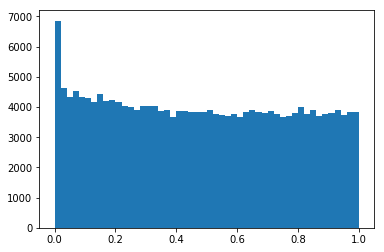

In [126]:
plt.hist(ps, 50)

In [128]:
max_nl = 2000000
l = 0
snp = []
with open(snpfile) as f:
    for line in f:
        ls = line.split()
        l += 1
        if l>max_nl:
            break
         
        if ls[0] == '1':
            snp.append(ls[1:3][::-1])
            

In [129]:
snp = dict(snp)

In [130]:
genes = np.unique([item[0].split('.')[0] for item in pair_data])

In [131]:
gene_dict = {}
with open(tssfile) as f:
    for line in f:
        ls = line.strip().split(',')
        if ls[0] in genes:
            gene_dict[ls[0]] = ls[-1]

In [132]:
data = []
for item in pair_data:
    g = item[0].split('.')[0]
    if g in gene_dict:
        x = gene_dict[g]
        #print x
        p = float(item[-1])
        
        tss_x = snp[item[1]]
        x = abs(int(tss_x) - int(x))
        data.append([x,p])
        
data = np.array(data)

In [133]:
from sideinfo import *

In [164]:
BH(data[:,1], alpha = 0.05)

(726, 0.00019156899999999999)

In [165]:
Storey_BH(data[:,1], alpha = 0.05)

(736, 0.00020438300000000001, 0.9538080120616248)

In [136]:
x = np.log(data[:,0])
p = data[:,1]

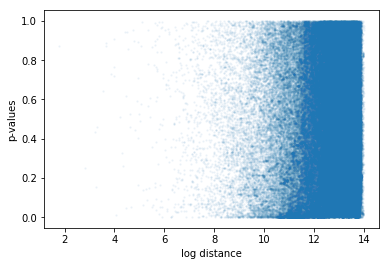

In [192]:
plt.scatter(x, p, 2, alpha = 0.05)
plt.xlabel('log distance')
plt.ylabel('p-values')
plt.savefig('1d5.png')

In [142]:
network = get_network(scale = 0.01)
optimizer = optim.Adagrad(network.parameters(), lr = 0.01)

In [143]:
p_target = np.ones(x.shape) * Storey_BH(p)[1]
loss_hist = train_network_to_target_p(network, optimizer, x, p_target, num_it = 3000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


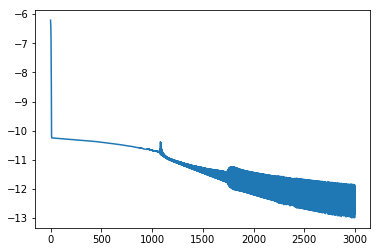

In [144]:
plt.plot(np.log(loss_hist))

In [171]:
#optimizer = optim.Adagrad(network.parameters(), lr = 0.01)
loss_hist, s, s2 = train_network(network, optimizer, x, p, num_it = 3000, lambda_=20, lambda2_ = 1e4)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


(Variable containing:
1.00000e-03 *
  5.4857
[torch.FloatTensor of size 1]
, Variable containing:
1.00000e-04 *
  2.7678
[torch.FloatTensor of size 1]
, Variable containing:
1.00000e-02 *
  5.0455
[torch.FloatTensor of size 1]
)


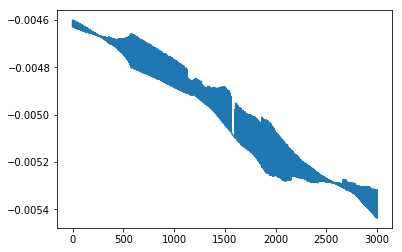

In [172]:
plt.plot(loss_hist)
print(s,s2, s2/s)

In [176]:
n_samples = len(x)
x_input = Variable(torch.from_numpy(x.astype(np.float32).reshape(n_samples ,1)))
p_input = Variable(torch.from_numpy(p.astype(np.float32).reshape(n_samples ,1)))
output = network.forward(x_input)
pred = (p_input < output).data.numpy()
pred = pred[:,0].astype(np.float32)

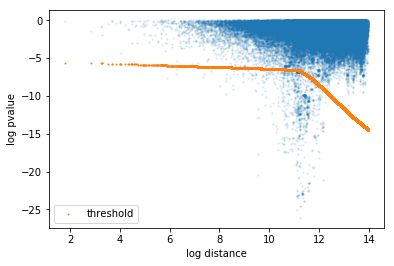

In [200]:
plt.scatter(x, np.log(p), 2, alpha = 0.1)
plt.scatter(x, np.log(output.data.numpy()), 1, label = 'threshold')
plt.legend()
plt.xlabel('log distance')
plt.ylabel('log pvalue')
plt.savefig('1d6.png')

In [178]:
sum(pred)

1009.0

(0, 0.1)

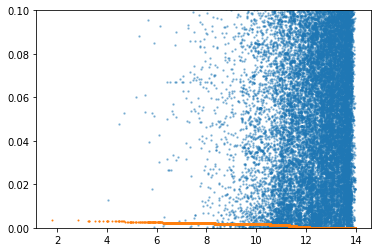

In [197]:
plt.scatter(x, p, 2, alpha = 0.4)
plt.scatter(x, output.data.numpy(), 1)
plt.ylim(0,0.1)

In [201]:
with open('gtex.csv', 'w') as f:
    f.write('x_value, p_value\n')
    for i in range(len(x)):
        f.write("{}, {}\n".format(x[i],p[i]))